# PD model simulation

In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
from math import log
%matplotlib notebook
from matplotlib import pyplot as plt

## Functions

### Simulating a PD model

The function `gen_pd_data` simulates a population of customers, each of which is assigned a default outcome (a 0 or 1 binary indicator) and a predicted probability of default. The default outcome is modelled through a "distance-to-default" approach, where we assign a default outcome of 1 whenever a certain standard normal variable is above a certain threshold. Using a correlation ("rho") parameter, we can arbitrarily decide how much of this standard normal variable we are able to predict, and assign predicted PDs accordingly.

In [2]:
def gen_pd_data(n,    # number of records in the final DataFrame
                rho,  # correlation between the predicted and the actual distance to default
                DR    # desired default rate (used to determine the DD threshold triggering default)
               ):
    pred = pd.Series(np.random.normal(size=n))
    cutoff = norm.ppf(DR)
    error = pd.Series(np.random.normal(size=n))
    X = (pred*np.sqrt(rho)) + (error*np.sqrt(1 - rho))
    def_flag = np.where(X > cutoff, 0, 1)
    pred_p_d = pred.apply(lambda x: 1 - norm.cdf((np.sqrt(rho)*x - cutoff)/np.sqrt(1 - rho)))
    pred_def_flag = np.where(pred > cutoff, 0, 1)
    df = pd.DataFrame({'OBSERVED' : def_flag, 'PREDICTED' : pred_p_d})
    return df

### Convert PD to a score

The function `pd_to_score` converts a series of PDs into a "score" using a designated function (e.g. logodds) and some optional rescaling parameters.

In [264]:
def pd_to_score(PD, transformation, intercept=0, slope=1, score_range=None, standardise=False):
    raw_score = PD.apply(transformation)
    try:
        low_score, high_score = score_range
    except TypeError:
        pass
    else:
        if standardise == True:
            min_raw_score = raw_score.min()
            max_raw_score = raw_score.max()
        else:
            min_raw_score = transformation(1e-10)
            max_raw_score = transformation(1 - 1e-10)
        slope = (high_score - low_score)/(min_raw_score - max_raw_score)
        intercept = high_score - (min_raw_score*slope)
    finally:
        result = (raw_score*slope) + intercept
        return result

### Create and apply PD bands

The two functions `create_banding` and `apply_banding` can be used sequentially to group a series of PD (or score) values into a specified number of bands based on percentiles. Alternatively, `apply_banding` can be used on its own to pass an arbitrary banding.

In [265]:
def create_banding(
    x,
    n = None,
    weight = 1,
    ):
    try:
        df = pd.DataFrame({'x' : x, 'weight' : weight}).dropna().sort_values('x')
    except:
        print("ERROR: Arguments 'x' or 'n' misspecified.")
        return
    sum_weights = df['weight'].sum()
    df['cumsum_weight'] = df['weight'].cumsum()
    percentiles = [(sum_weights/n)*group for group in range(n+1)]
    index_val = 0
    banding = []
    for pctl in percentiles:
        while df['cumsum_weight'].iloc[index_val] < pctl:
            index_val += 1
        banding.append(df['x'].iloc[index_val])
    banding = np.unique(banding)
    banding[[0, -1]] = np.array([-np.inf, np.inf])
    return banding

In [266]:
def apply_banding(
    *args,
    label_prefix = 'BAND_',
    **kwargs
    ):
    try:
        n_bins = len(kwargs['bins'])
    except KeyError as error:
        try:
            n_bins = len(args[1])
        except IndexError as error:
            print(f"ERROR: Please provide an array-like banding to apply using the 'bins' argument!")
            return
    try:
        labels = kwargs.pop('labels')
    except KeyError:
        labels = [f'{label_prefix}{number}' for number in range(1, n_bins)]
    kwargs['retbins'] = False
    kwargs['right'] = False
    result = pd.cut(*args, labels=labels, **kwargs)
    return result

### Utility

In [284]:
as_pct = lambda x: f'{round(x*100, 2)}%'

In [324]:
def cap_floor(x, floor=None, cap=None):
    try:
        x_floored = np.max([x, floor])
    except TypeError:
        x_floored = x
    try:
        x_floored_capped = np.min([x_floored, cap])
    except TypeError:
        x_floored_capped = x_floored
    return x_floored_capped

## Simulated portfolio

Let's simulate a portfolio made of two segments, characterised by different risk, as well as different PD models.

In [3]:
np.random.seed(1)

In [4]:
SEG1 = gen_pd_data(n=10000, rho=0.5, DR=0.01)
SEG1['SEGMENT'] = 'SEG1'

In [5]:
SEG2 = gen_pd_data(n=400, rho=0.8, DR=0.11)
SEG2['SEGMENT'] = 'SEG2'

In [316]:
SEG1.describe().drop('count').applymap(as_pct)

OBSERVED PREDICTED
mean    0.95%     1.03%
std      9.7%     3.76%
min      0.0%      0.0%
25%      0.0%      0.0%
50%      0.0%     0.05%
75%      0.0%     0.45%
max    100.0%    77.39%

In [315]:
SEG2.describe().drop('count').applymap(as_pct)

OBSERVED PREDICTED
mean    9.75%    10.86%
std     29.7%    21.21%
min      0.0%      0.0%
25%      0.0%      0.0%
50%      0.0%     0.35%
75%      0.0%     9.63%
max    100.0%    99.89%

Let's now combine the two segments in a portfolio.

In [6]:
portfolio = SEG1.append(SEG2)

In [7]:
portfolio.head()

OBSERVED     PREDICTED SEGMENT
0         0  4.455055e-07    SEG1
1         0  3.700991e-03    SEG1
2         0  2.874352e-03    SEG1
3         0  1.331209e-02    SEG1
4         0  1.623876e-05    SEG1

In [311]:
portfolio.groupby('SEGMENT').mean().applymap(lambda x: f'{round(x*100, 2)}%')

OBSERVED PREDICTED
SEGMENT                   
SEG1       0.95%     1.03%
SEG2       9.75%    10.86%

### Converting PD into a score

We can use the function `pd_to_score` to map PDs to a score, where a lower score stands for higher risk.

In [336]:
pd_cap_floor = lambda x: cap_floor(x, 0.000001, 0.999999)
normal_ppf = lambda x: norm.ppf(pd_cap_floor(x))

In [337]:
portfolio['SCORE'] = pd_to_score(portfolio['PREDICTED'],
                                 normal_ppf,
                                 score_range = [0, 100],
                                 standardise = True
                                )

In [338]:
portfolio.describe()

OBSERVED     PREDICTED         SCORE
count  10400.000000  10400.000000  1.040000e+04
mean       0.012885      0.014080  8.053758e+01
std        0.112782      0.058662  1.269300e+01
min        0.000000      0.000000 -1.421085e-14
25%        0.000000      0.000036  7.227309e+01
50%        0.000000      0.000542  8.100932e+01
75%        0.000000      0.004876  8.997232e+01
max        1.000000      0.998927  1.000000e+02

### Applying alternative PD bands

We can now look at how our simulated model performs under different banding approaches.

**1. Equal population bands**

In [387]:
ten_pct_TOTAL = create_banding(portfolio['SCORE'], 10)
print(ten_pct_TOTAL)

[       -inf 64.23185694 70.10315292 74.20348531 77.67697149 81.00772525
 84.54019873 88.01526806 92.26681091 98.05638843         inf]


**2. Equal BAD population bands**

In [388]:
ten_pct_BAD = create_banding(portfolio.loc[portfolio['OBSERVED'] == 1, 'SCORE'], 10)
print(ten_pct_BAD)

[       -inf 30.74947831 36.93376441 44.43247667 51.57612707 54.70049964
 58.35086424 61.72669704 64.40956099 68.84351516         inf]


**3. Ten point score bands**

In [389]:
ten_point_score = np.array([-np.inf, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf])

We can now apply each of the bandings we have created using the `apply_banding` function.

In [390]:
banding_options = ['ten_point_score', 'ten_pct_BAD', 'ten_pct_TOTAL']
for banding in banding_options:
    portfolio[banding] = apply_banding(portfolio['SCORE'], bins=eval(banding), label_prefix='SCORE_')

In [391]:
portfolio.head()

OBSERVED     PREDICTED SEGMENT       SCORE ten_point_score ten_pct_BAD  \
0         0  3.033655e-02    SEG1   63.214636         SCORE_7     SCORE_8   
1         0  3.081190e-03    SEG1   74.248676         SCORE_8    SCORE_10   
2         0  1.167901e-07    SEG1  100.000000        SCORE_10    SCORE_10   
3         0  9.469353e-07    SEG1  100.000000        SCORE_10    SCORE_10   
4         0  1.582197e-03    SEG1   76.962450         SCORE_8    SCORE_10   

  ten_pct_TOTAL  
0       SCORE_1  
1       SCORE_4  
2      SCORE_10  
3      SCORE_10  
4       SCORE_4

### Actuals v. expected

In [513]:
def actual_v_expected(actual,   #sequence-like
                      expected, #sequence-like
                      banding,  #either sequence-like, or a banding to be applied using apply_banding
                      ):
    df = pd.DataFrame({'actual' : actual, 'expected' : expected})
    try:
        df['banding'] = banding
    except ValueError:
        df['banding'] = apply_banding(df['expected'], banding)
    result = df.groupby('banding')['actual', 'expected'].mean()
    return result

In [514]:
(actual_v_expected(portfolio['OBSERVED'],
                  portfolio['PREDICTED'],
                  portfolio['ten_pct_BAD']).
     applymap(as_pct))

actual expected
banding                  
SCORE_1   92.86%   85.35%
SCORE_2   72.22%   65.62%
SCORE_3   33.33%   45.03%
SCORE_4   12.04%   23.18%
SCORE_5   10.92%   13.69%
SCORE_6    7.78%    8.77%
SCORE_7    5.02%    5.12%
SCORE_8    4.39%    3.13%
SCORE_9    1.73%    1.61%
SCORE_10   0.16%    0.13%

In [515]:
(actual_v_expected(portfolio['OBSERVED'],
                  portfolio['PREDICTED'],
                  portfolio['ten_pct_TOTAL']).
     applymap(as_pct))

actual expected
banding                 
SCORE_1   10.2%   11.79%
SCORE_2   1.83%    1.44%
SCORE_3   0.58%     0.5%
SCORE_4    0.1%    0.21%
SCORE_5   0.19%    0.09%
SCORE_6    0.0%    0.03%
SCORE_7    0.0%    0.01%
SCORE_8    0.0%     0.0%
SCORE_9    0.0%     0.0%
SCORE_10   0.0%     0.0%

# Plotting

<IPython.core.display.Javascript object>


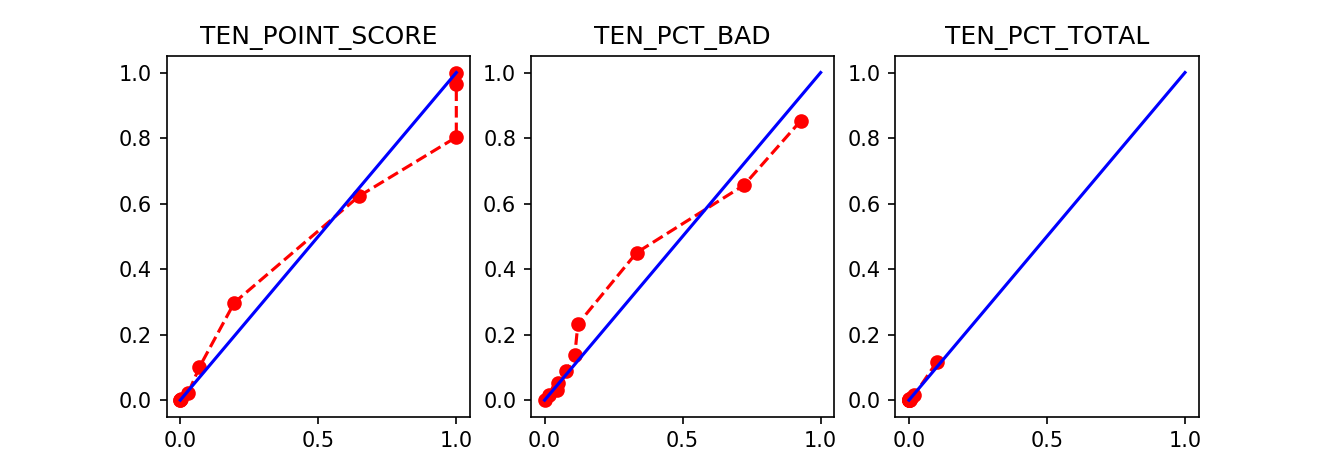

In [536]:
AvE = plt.figure()

In [537]:
for i, banding in enumerate(banding_options):
    plot_input = actual_v_expected(portfolio['OBSERVED'], portfolio['PREDICTED'], portfolio[banding])
    AvE.add_subplot(1, 3, i + 1)
    plt.plot(plot_input['actual'], plot_input['expected'], 'ro--')
    plt.plot([0, 1], [0, 1], 'b')
    plt.title(banding.upper())

# SCRATCH

In [3]:
np.random.seed(1)

In [4]:
SEG1 = gen_pd_data(n=10000, rho=0.2, DR=0.015)
SEG1['SEGMENT'] = 'SEG1'

In [5]:
SEG2 = gen_pd_data(n=400, rho=0.8, DR=0.11)
SEG2['SEGMENT'] = 'SEG2'

In [6]:
portfolio = SEG1.append(SEG2)

In [7]:
portfolio.to_csv('C:\\Users\\ludann\\Documents\\SAS learning material\\PD_data.csv', index=False)